### Imports

In [1]:
from sklearn.model_selection import train_test_split
from LondonEmotions import data, trainer, utils, main
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Sequential, Model

### Variables

In [2]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'worry', 'anger', 'sad', 'neutral']

### Load Data

In [26]:
def load_data():
    df = data.retrieve_data()
    df = data.clean_data(df)
    X = df['tokenized_text']
    y = df['Emotion']
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    sentences_train = [[_ for _ in sentence] for sentence in X_train]
    sentences_test = [[_ for _ in sentence] for sentence in X_test]
    
    return sentences_train, y_train, sentences_test, y_test

sentences_train, y_train, sentences_test, y_test = load_data()

In [28]:
# texts = [' '.join([word for sentence in sentences_train for word in sentence])]

texts_train = [' '.join([x for x in sentence]) for sentence in sentences_train]
texts_test = [' '.join([x for x in sentence]) for sentence in sentences_test]

In [29]:
print(texts_train[92])

that sound all right to


### Tokenize text

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 11630


### Pad text sentences

In [31]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,  759,   16,  491],
       [   0,    0,    0, ...,    5, 1993,   17],
       [   0,    0,    0, ...,    7,   13,   83],
       ...,
       [   0,    0,    0, ...,    2,  229,  197],
       [   0,    0,    0, ...,   33,   45,  142],
       [   0,    0,    0, ...,   67,    1,  558]], dtype=int32)

In [32]:
y_train.value_counts()

anger      1837
joy        1597
worry      1368
neutral    1214
sad         984
Name: Emotion, dtype: int64

### Encode target

In [33]:
encoding = {
    'anger': 0,
    'joy': 1,
    'worry': 2,
    'neutral': 3,
    'sad': 4
}

# Integer labels
y_train_enc = [encoding[x] for x in y_train]
y_test_enc = [encoding[x] for x in y_test]

In [34]:
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

### Create embedding matrix

In [35]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

file_path = '../embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [36]:
file_path = '../embeddings/wiki-news-300d-1M.vec'
embedd_matrix = create_embedding_matrix(file_path, index_of_words, embed_num_dims)
embedd_matrix.shape

(11631, 300)

In [37]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 8020
New words found: 3610


### Define model

In [38]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3489300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 256)          230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 3,787,033
Trainable params: 297,733
Non-trainable params: 3,489,300
_________________________________________________________________


### Train model

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 256
epochs = 3
es = EarlyStopping(patience=1, restore_best_weights=True)

hist = model.fit(X_train_pad, y_train_cat, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_split=0.3,
                 callbacks=[es])

Epoch 1/6
20/20 [==============================] - 52s 3s/step - loss: 1.5483 - accuracy: 0.3233 - val_loss: 1.4701 - val_accuracy: 0.3676
Epoch 2/6
20/20 [==============================] - 48s 2s/step - loss: 1.3719 - accuracy: 0.4290 - val_loss: 1.3738 - val_accuracy: 0.4229
Epoch 3/6
20/20 [==============================] - 48s 2s/step - loss: 1.2112 - accuracy: 0.5239 - val_loss: 1.3099 - val_accuracy: 0.4724
Epoch 4/6
20/20 [==============================] - 45s 2s/step - loss: 1.0424 - accuracy: 0.6247 - val_loss: 1.2856 - val_accuracy: 0.4852
Epoch 5/6
20/20 [==============================] - 51s 3s/step - loss: 0.8839 - accuracy: 0.6910 - val_loss: 1.2678 - val_accuracy: 0.4995
Epoch 6/6
20/20 [==============================] - 68s 3s/step - loss: 0.7228 - accuracy: 0.7749 - val_loss: 1.3401 - val_accuracy: 0.4867


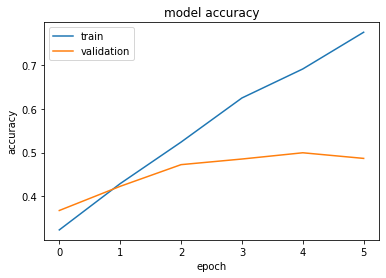

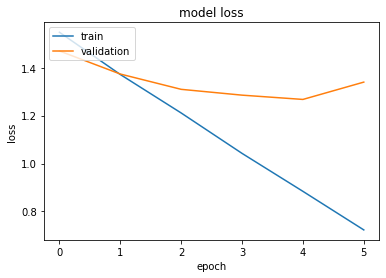

In [40]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [42]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [43]:
y_test

51467    neutral
35546      anger
13552      worry
19228      worry
12611        joy
58492    neutral
7243       worry
30903      anger
51831    neutral
31716      anger
28521      worry
4815         sad
6512       worry
7757         joy
17704        joy
35312      anger
54561    neutral
21620        joy
58085    neutral
58025    neutral
39491      anger
56122    neutral
4242       worry
14479        joy
8944       worry
39755      anger
51304    neutral
58936    neutral
58718    neutral
10323      worry
          ...   
51278    neutral
42931        joy
53730    neutral
21408        joy
2462       worry
58977    neutral
32517      anger
53743    neutral
32560      anger
53535    neutral
11509      worry
34446        joy
49405        joy
50037      anger
14346        joy
203        worry
33502      anger
51599    neutral
53343    neutral
37498      anger
10140        sad
58141    neutral
59632    neutral
6122       anger
8695         joy
9743       anger
29785      anger
54653    neutr

In [44]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, predictions, average='micro') * 100))

Accuracy: 11.83%

F1 Score: 11.83
